### Set paths and Import libraries 

In [11]:
import os
import sys
# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
csvpath = '~/code/nn_orthoreplay/' #  path to the csv files


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm  # Import cm for colormap functionality
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
# Import helper functions from stateformation_get_input_output.py:
from stateformation_get_input_output_passive import get_input_output_stateformation
from stateformation_get_input_output_passive import get_active_trials_input_comb
from stateformation_get_input_output_passive import rewardfun
from stateformation_get_input_output_passive import input2state

# which subjects to use (set to subset to increase speed ...)
subjs = ['sub501', 'sub502', 'sub503', 'sub504', 'sub505', 'sub506', 'sub507', 'sub508', 'sub509', 'sub510',
 'sub511', 'sub512', 'sub513', 'sub514', 'sub515'] 

allsubjs = ['sub501', 'sub502', 'sub503', 'sub504', 'sub505', 'sub506', 'sub507', 'sub508', 'sub509', 'sub510',
 'sub511', 'sub512', 'sub513', 'sub514', 'sub515', 'sub516', 'sub517', 'sub518', 'sub519', 
  'sub521', 'sub522', 'sub523', 'sub524', 'sub525', 'sub526', 'sub527', 'sub528', 'sub529', 'sub530', 
  'sub531', 'sub532', 'sub533', 'sub534', 'sub535', 'sub536', 'sub537', 'sub538', 'sub539', 'sub540', 
  'sub541', 'sub542', 'sub543', 'sub544', 'sub545', 'sub546', 'sub547', 'sub548', 'sub549', 'sub550', 
  'sub551', 'sub552', 'sub553', 'sub554', 'sub555', 'sub556', 'sub557', 'sub558', 'sub559', 'sub560', 
  'sub561', 'sub562', 'sub563', 'sub564'] 



### Define Custom functions for averaging etc 

In [ ]:
# Function to compute running average
def running_average(data, window_size):
    kernel = np.ones(window_size) / window_size
    if data.ndim == 1:  # For 1D arrays
        return np.convolve(data, kernel, mode='valid')
    elif data.ndim == 2:  # For 2D arrays
        return np.array([np.convolve(row, kernel, mode='valid') for row in data])
    else:
        raise ValueError("Input data must be 1D or 2D.")

# Function to compute marginal means
def prep_marginal_means(cdim, loss_array, acc_array, window_size=15):
    """
    Compute running averages for loss and accuracy based on the specified dimension (cdim).

    Args:
        cdim (int): The dimension to marginalize over (0 for learning rates, 1 for RNN gains, 2 for FC gains).
        loss_array (np.ndarray): The array of losses with shape (n_lr, n_rg, n_fg, n_subj, n_trials).
        acc_array (np.ndarray): The array of accuracies with shape (n_lr, n_rg, n_fg, n_subj, n_trials).
        window_size (int): The window size for the running average.

    Returns:
        running_avg_loss (np.ndarray): Running averages of losses.
        running_avg_accuracy (np.ndarray): Running averages of accuracies.
    """
    axes = tuple({0, 1, 2, 3} - {cdim})
    cmeanloss = np.mean(loss_array, axis=axes)  # Mean over marginalized dimensions
    cmeanacc = np.mean(acc_array, axis=axes)  # Mean over marginalized dimensions
    running_avg_loss = running_average(cmeanloss, window_size=window_size)
    running_avg_accuracy = running_average(cmeanacc, window_size=window_size)
    dimsize = running_avg_loss.shape[0]
    return running_avg_loss, running_avg_accuracy, dimsize

def prepare_data(sub, csvpath, isRecurrent=True):
    # Load the data using the provided helper function
    inputs, targets, isPassive, states = get_input_output_stateformation(sub=sub,csvpath = csvpath, isRecurrent=isRecurrent, withPassive = True)   
    #inputs, targets = get_input_output_stateformation(sub=sub, csvpath=csvpath, isRecurrent=isRecurrent)
    
    # Transform inputs
    inputs = np.transpose(inputs, (1, 2, 0))  # Rearrange dimensions
    inputs = inputs[np.newaxis, :, :, :]  # Add a new axis for batch size
    passive_inputs = inputs[:,:,:,isPassive == 1]  # Inputs where isPassive is True
    active_inputs = inputs[:,:,:,isPassive == 0]  # Inputs where isPassive is False

    inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to PyTorch tensor
    passive_inputs = torch.tensor(passive_inputs, dtype=torch.float32)  # Convert to PyTorch tensor
    active_inputs = torch.tensor(active_inputs, dtype=torch.float32)  # Convert to PyTorch tensor

    # Transform targets
    targets = np.transpose(targets, (1, 0))  # Rearrange dimensions
    targets = targets[np.newaxis, :, :]  # Add a new axis for batch size
    passive_targets = targets[:,:,isPassive == 1]  # targets where isPassive is True
    active_targets = targets[:,:,isPassive == 0]  # targets where isPassive is False
    
    targets = torch.tensor(targets, dtype=torch.float32)  # Convert to PyTorch tensor
    passive_targets = torch.tensor(passive_targets, dtype=torch.float32)  # Convert to PyTorch tensor
    active_targets = torch.tensor(active_targets, dtype=torch.float32)  # Convert to PyTorch tensor
    
    return inputs, active_inputs, passive_inputs, targets, active_targets, passive_targets, states

# weight initialization function
def initialize_weights(module, rnn_gain=1.0, fc_gain=1.0):
    if isinstance(module, nn.RNN):  # For recurrent layers
        for name, param in module.named_parameters():
            if 'weight' in name:
                init.torch.nn.init.xavier_uniform_(param, gain = rnn_gain)  # Uniform initialization with SD for RNN
            elif 'bias' in name:
                init.zeros_(param)  # Initialize biases to zero
    elif isinstance(module, nn.Linear):  # For fully connected layers
        init.torch.nn.init.xavier_uniform_(module.weight, gain = fc_gain)  # Uniform initialization with SD for FC
        if module.bias is not None:
            init.zeros_(module.bias)  # Initialize biases to zero


### Basic Network Settings 

In [13]:
# network shape parameters
output_dim = 1
batch_size = 1
n_steps = 2
input_dim = 10
n_trials = 256
n_subj = len(subjs)
hidden_fan_factor = 4 
hidden_rnn_dim = input_dim*hidden_fan_factor
hidden_fc_dim = input_dim*hidden_fan_factor

### Define Network class (determines architecture)

In [14]:
# Define network
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_rnn_dim, hidden_fc_dim, output_dim):
        super(SimpleRNN, self).__init__()
        # Recurrent hidden layer
        self.rnn = nn.RNN(input_dim, hidden_rnn_dim, nonlinearity=hidden_rnn_activation, bias=True, batch_first=True)
        # Fully connected hidden layer
        self.fc_hidden = nn.Linear(hidden_rnn_dim, hidden_fc_dim, bias=True)
        # Output layer
        self.output = nn.Linear(hidden_fc_dim, output_dim, bias=True)
       
        # Dynamically set the activation function for the fully connected hidden layer
        if hidden_fc_activation == 'relu':
            self.hidden_activation = nn.ReLU()
        elif hidden_fc_activation == 'tanh':
            self.hidden_activation = nn.Tanh()
        elif hidden_fc_activation == 'sigmoid':
            self.hidden_activation = nn.Sigmoid()
        elif hidden_fc_activation == 'linear':
            self.hidden_activation = nn.Identity()  # No activation (linear output)
        else:
            raise ValueError(f"Unsupported activation function: {hidden_fc_activation}")
        
        # Dynamically set the activation function for the output layer
        if output_activation == 'relu':
            self.output_activation = nn.ReLU()
        elif output_activation == 'tanh':
            self.output_activation = nn.Tanh()
        elif output_activation == 'sigmoid':
            self.output_activation = nn.Sigmoid()
        elif output_activation == 'softmax':
            self.output_activation = nn.Softmax(dim=1)  # Softmax for classification
        elif output_activation == 'linear':
            self.output_activation = nn.Identity()  # No activation (linear output)
        else:
            raise ValueError(f"Unsupported activation function: {output_activation}")

    def forward(self, x):
        # Pass through RNN layer
        rnn_out, _ = self.rnn(x)  # x should have shape (batch_size, n_steps, input_dim)
        # Take the output of the last time step
        rnn_last_out = rnn_out[:, -1, :]  # Shape: (batch_size, hidden_rnn_dim)
        # Pass through fully connected hidden layer
        fc_hidden_out = self.hidden_activation(self.fc_hidden(rnn_last_out))
        # Pass through output layer
        output = self.output_activation(self.output(fc_hidden_out))
        return output, rnn_last_out, fc_hidden_out



In [21]:
ctrial = 1
inputs, targets, isPassive, states = get_input_output_stateformation(sub=subjs[1],csvpath = csvpath, isRecurrent=True, withPassive = True)   
print(inputs.shape)
inputs = np.transpose(inputs, (1, 2, 0))  # Rearrange dimensions
inputs = inputs[np.newaxis, :, :, :]  # Add a new axis for batch size
print(inputs.shape)    
#inputs, active_inputs, passive_inputs, targets, active_targets, passive_targets, states = prepare_data(subjs[1], csvpath, isRecurrent=True)


#trial_input = inputs[:, :, :, ctrial]
#trial_target = targets[:, :, ctrial]   
#print(trial_input.shape)
outputs = []  # Initialize a list to store outputs for both steps
cstep = 1
#ctrial_input = trial_input[:, :, cstep]
# output, rnn_last_out, fc_hidden_out = model(ctrial_input)
#outputs.append(output)  # Store the output for this step
                    

(440, 2, 16)
(1, 2, 16, 440)


### Run network with different learning rates / gains etc for subset of subjs and stroe results 

In [5]:
results = {
    "losses": {},
    "accuracies": {},
    "rewards": {},
    "pes": {}
}

hidden_rnn_activation = 'relu'
hidden_fc_activation = 'relu'
output_activation = 'linear' 

learning_rates = [0.005, 0.01, 0.02, 0.03, 0.04]  # From 1e-5 to 1e-1 with 10 steps
rnn_gains = [0.5, 0.75, 1.0, 2.0, 4.0]  # RNN gain values
fc_gains = [0.5, 0.75, 1.0, 2.0, 4.0]  # RNN gain values
n_lr = len(learning_rates)
n_rg = len(rnn_gains)
n_fg = len(fc_gains)

for learning_rate in learning_rates:
    results["losses"][learning_rate] = {}
    results["accuracies"][learning_rate] = {}
    results["rewards"][learning_rate] = {}
    results["pes"][learning_rate] = {}
    print(f"Starting loop for learning_rate: {learning_rate}")
    for rnn_gain in rnn_gains:
        results["losses"][learning_rate][rnn_gain] = {}
        results["accuracies"][learning_rate][rnn_gain] = {}
        results["rewards"][learning_rate][rnn_gain] = {}
        results["pes"][learning_rate][rnn_gain] = {}
        #print(f"  Starting loop for rnn_gain: {rnn_gain}")
        for fc_gain in fc_gains:
            results["losses"][learning_rate][rnn_gain][fc_gain] = {}
            results["accuracies"][learning_rate][rnn_gain][fc_gain] = {}
            results["rewards"][learning_rate][rnn_gain][fc_gain] = {}
            results["pes"][learning_rate][rnn_gain][fc_gain] = {}
            #print(f"    Starting loop for fc_gain: {fc_gain}")
            for csub in subjs:
                inputs, active_inputs, passive_inputs, targets, active_targets, passive_targets, states = prepare_data(csub, csvpath, isRecurrent=True)
                model = SimpleRNN(input_dim, hidden_rnn_dim, hidden_fc_dim, output_dim)
                model.apply(lambda module: initialize_weights(module, rnn_gain=rnn_gain, fc_gain=fc_gain))
                criterion = nn.SmoothL1Loss()
                optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
                subj_losses = []
                subj_accuracies = []
                subj_rewards = []
                subj_pes = []
                model.train()
                for ctrial in range(n_trials):
                    optimizer.zero_grad()
                    trial_input = inputs[:, :, :, ctrial]
                    trial_target = targets[:, :, ctrial]   
                    outputs = []  # Initialize a list to store outputs for both steps
                    for cstep in range(2): 
                        ctrial_input = trial_input[:, :, cstep]
                        output, rnn_last_out, fc_hidden_out = model(ctrial_input)
                        outputs.append(output)  # Store the output for this step
                    
                    # Compare the two outputs and get the index of the maximum one
                    outputs_tensor = torch.stack(outputs)  # Stack outputs into a tensor of shape (2, batch_size, output_dim)
                    predicted_node = torch.argmax(outputs_tensor, dim=0)  # Get the index of the maximum value along the first dimension (steps)

                    ctrial_input = trial_input[:, :, predicted_node]
                    output, rnn_last_out, fc_hidden_out = model(ctrial_input)
                    target_node = torch.argmax(trial_target, dim=1)  # Index of the maximum target node    
                    reward = trial_target[0, predicted_node.item()]
                    target_value = trial_target[:, predicted_node.item()].unsqueeze(1)
                    loss = criterion(output, target_value)
                    loss.backward()
                    optimizer.step()
                    subj_losses.append(loss.item())
                    subj_rewards.append(reward.item())
                    subj_accuracies.append((predicted_node == target_node).float().mean().item())
                    subj_pes.append(np.abs(predicted_node.item() - target_node.item()))  # Example PE calculation
                results["losses"][learning_rate][rnn_gain][fc_gain][csub] = subj_losses
                results["rewards"][learning_rate][rnn_gain][fc_gain][csub] = subj_rewards
                results["accuracies"][learning_rate][rnn_gain][fc_gain][csub] = subj_accuracies
                results["pes"][learning_rate][rnn_gain][fc_gain][csub] = subj_pes
            # Print after finishing all trials for a subject
            print(".", end="")
        # Print after finishing all subjects for a specific fc_gain
        print("*", end="")
    # Print after finishing all fc_gain loops for a specific rnn_gain
    print(f"->Finished loop")
# Print after finishing all rnn_gain loops for a specific learning_rate
print("ALL DONE!!")


Starting loop for learning_rate: 0.005


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


RuntimeError: input.size(-1) must be equal to input_size. Expected 10, got 2

### Find best Network and plot avg performance 

Indices of maximum mean accuracy: (3, 2, 2)
Maximum mean accuracy: 0.9833333333333333
(256,)


Text(0.5, 1.0, 'net with alpha 0.03 gain 1.0')

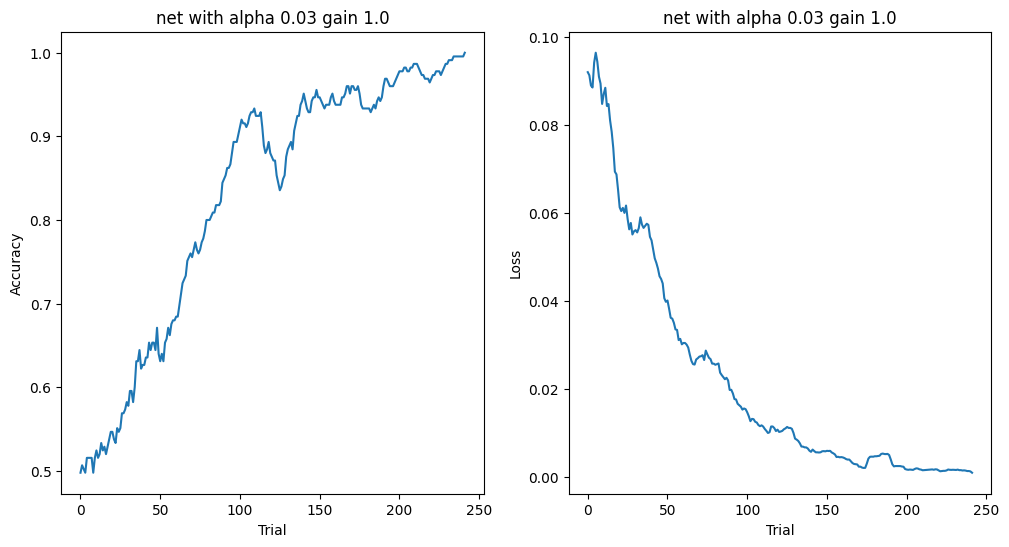

In [ ]:
# Initialize an array to store the losses
loss_array = np.zeros((n_lr, n_rg, n_fg, n_subj, n_trials))
acc_array = np.zeros((n_lr, n_rg, n_fg, n_subj, n_trials))

# Populate the array
for lr_idx, learning_rate in enumerate(learning_rates):
    for rnn_idx, rnn_gain in enumerate(rnn_gains):
        for fc_idx, fc_gain in enumerate(fc_gains):
            for subj_idx, subject in enumerate(subjs):
                loss_array[lr_idx, rnn_idx, fc_idx, subj_idx, :] = results['losses'][learning_rate][rnn_gain][fc_gain][subject]
                acc_array[lr_idx, rnn_idx, fc_idx, subj_idx, :] = results['accuracies'][learning_rate][rnn_gain][fc_gain][subject]

mean_acc = np.mean(acc_array[:, :, :, :, 200:n_trials], axis=(3,4))  # Shape: (len(learning_rates), 3, 3, n_subj)
# Find the indices of the maximum mean accuracy
max_indices = np.unravel_index(np.argmax(mean_acc), mean_acc.shape)

print("Indices of maximum mean accuracy:", max_indices)
print("Maximum mean accuracy:", mean_acc[max_indices])

# plotting 
best_net_acc = np.mean(acc_array[max_indices[0], max_indices[1], max_indices[2], :,:], axis=(0))
best_net_loss = np.mean(loss_array[max_indices[0], max_indices[1], max_indices[2], :,:], axis=(0))
print(best_net_acc.shape)
best_net_acc_s = running_average(best_net_acc, window_size=15)
best_net_loss_s = running_average(best_net_loss, window_size=15)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(best_net_acc_s)
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.title(f'net with alpha {learning_rates[max_indices[0]]} gain {rnn_gains[max_indices[1]]}')

plt.subplot(1, 2, 2)
plt.plot(best_net_loss_s)
plt.xlabel("Trial")
plt.ylabel("Loss")
plt.title(f'net with alpha {learning_rates[max_indices[0]]} gain {rnn_gains[max_indices[1]]}')



### Plot color map of net performance over param space 

[[0.63619048 0.695      0.77619048 0.8752381  0.8847619 ]
 [0.71595238 0.78261905 0.86452381 0.90547619 0.85761905]
 [0.80166667 0.85       0.8697619  0.87333333 0.72452381]
 [0.80285714 0.8552381  0.86666667 0.85095238 0.60214286]
 [0.79238095 0.82547619 0.84857143 0.81547619 0.5602381 ]]


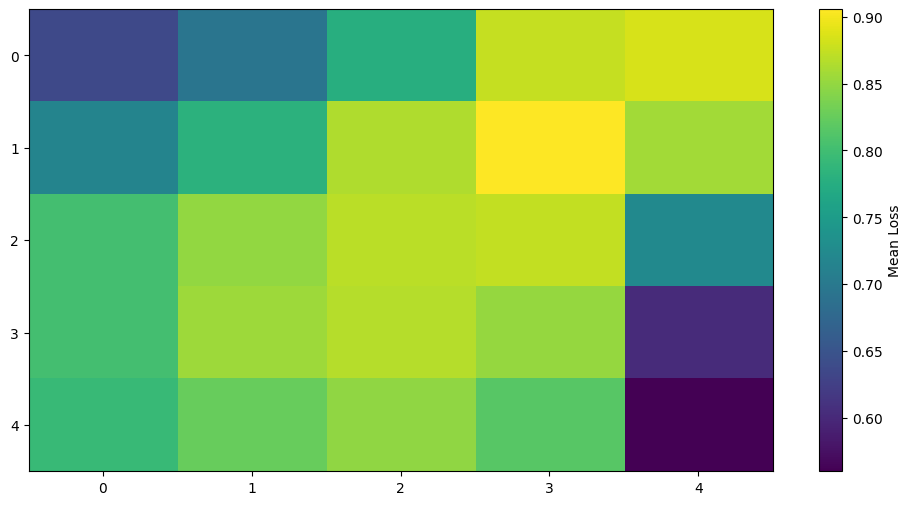

In [ ]:
cmap = np.nanmean(acc_array[:, :, :, :, 200:n_trials], axis=(2,3,4))
plt.figure(figsize=(12, 6))
plt.imshow(cmap, cmap='viridis', aspect='auto')
plt.colorbar(label='Mean Loss')
print(cmap)


### plot marginal learning curves to see variation in params 

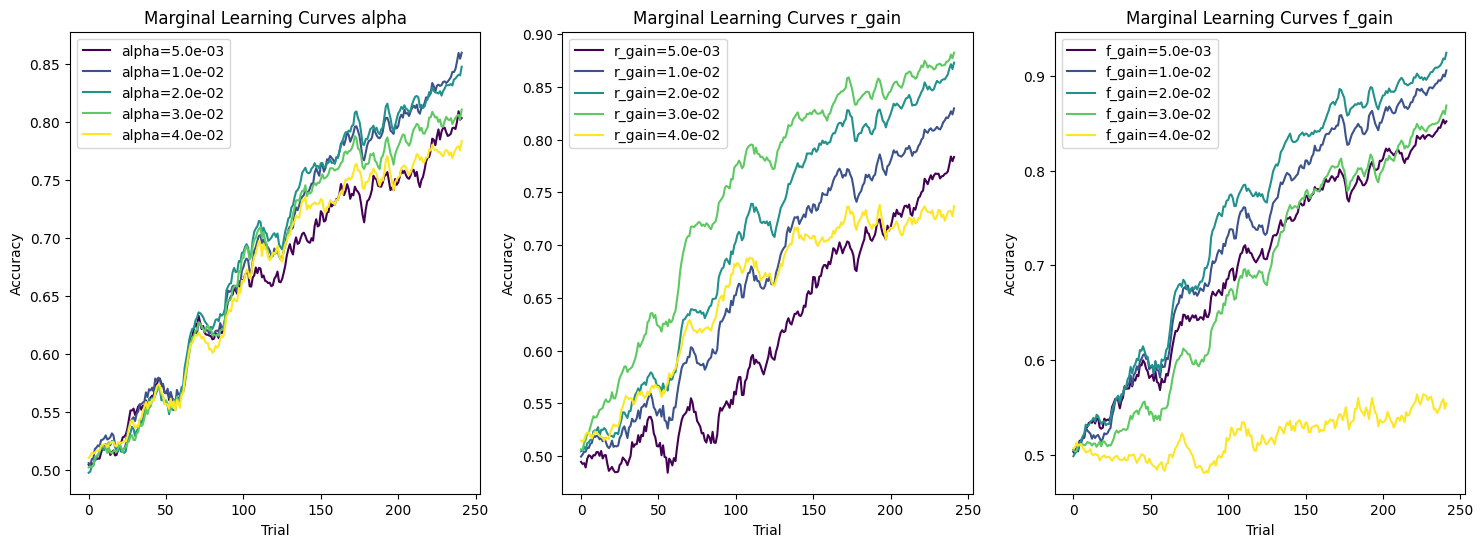

In [ ]:

mar_dim_names = ['alpha', 'r_gain', 'f_gain']  # Convert to a list for indexing
# Plot the running averages
plt.figure(figsize=(18, 6))

for cdim in range(3):
    running_avg_loss, running_avg_accuracy, dimsize = prep_marginal_means(cdim = cdim, loss_array=loss_array, acc_array=acc_array, window_size=15)
    plt.subplot(1, 3, cdim+1)
    colors = cm.viridis(np.linspace(0, 1, n_lr))  # Generate a continuous color scale
    for idx in range(dimsize):
        plt.plot(running_avg_accuracy[idx, :], label=f"{mar_dim_names[cdim]}={learning_rates[idx]:.1e}", color=colors[idx])
        plt.legend()
        plt.xlabel("Trial")
        plt.ylabel("Accuracy")
        plt.title(f"Marginal Learning Curves {mar_dim_names[cdim]}")

plt.show()

